In [1]:
# Libraries etc
%matplotlib inline
import numpy as np
import seaborn as sns
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from plinkio import plinkfile
import glob
from scipy.stats import chi2
chi2sf = chi2.sf
import sys
import os
import pdb
import scipy

from matplotlib import gridspec

In [2]:
# Local paths, constants ...
home = "/srv/gsfs0/projects/bustamante/apoursh_projects/Hydra"
scratch = "/local/scratch/armin/Hydra/"
fig_dir = "figures/"
# scratch = "testHydra/"
_EPS = 1e-200
centers = ["MEC_CA_ppl.h5py", "BioME_ppl.h5py", "WHI_ppl.h5py", "MEC_HI_ppl.h5py",
           "SOL_M_ppl.h5py", "SOL_B_ppl.h5py","SOL_C_ppl.h5py", "SOL_S_ppl.h5py"]

In [3]:
def manhattan(data, chrom, pval = "pCoef",ax=None, plot_type='scatter', alpha=.7, line=True, **kwargs):
    sns.set(font_scale=1)
    sns.set_style("white")
    sns.despine(left=True)
    colors = sns.color_palette("hls", 8)[5:7]
    y = -np.log10(data[pval] + _EPS)
    x = np.array(range(len(data[pval])))
    c = np.array([colors[int(i)%2] for i in data.chrom])
    
    edge_clearance = 1000
    
    if ax is None: 
        fig, ax = plt.subplots(figsize=(12,6))
    
    if plot_type == 'scatter':
        ax.scatter(x, y, c=c, alpha=alpha, edgecolors='none', **kwargs)

    if line:
        ax.axhline(-np.log10(.01/len(y)), color='.5', linestyle='--')

#     if xtick_label_set is None: 
#     xtick_label_set = set(xs_by_id.keys())
    ax.set_xlim(-edge_clearance, len(x)+edge_clearance)
    ax.set_ylim(ymin=np.nanmin(y))
    
#    ax.set_xlabel("chromosome 1") 
    
    chroms, count = np.unique(data.chrom, return_counts=True)
    # Find the center point to place the label
    tick_pos, labels = [], []
    i = 0
    for c, n in zip(chroms, count):
        tick_pos.append(i + n/2)
        i += n
        if c < 11 or c % 2 ==0:
            labels.append(c)
        else:
            labels.append('')
    
    # last tick tends to have too little room 
    tick_pos[-1] += edge_clearance
    
    ax.set_xticks(tick_pos)
    #ax.set_xticklabels(labels=sorted(chroms.astype(int))) 
    ax.set_xticklabels(labels=labels)
    ax.set_ylabel(r'$-\log_{10}($P$)$',fontsize=16)
    sns.despine(fig=None, ax=ax, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

    return fig, ax


In [4]:
def manhattan_diff(data, y,ax=None, plot_type='scatter', alpha=.7, liney=0, y_min=-2.7, y_max=1.1, **kwargs):
    sns.set(font_scale=1)
    sns.set_style("white")
    sns.despine(left=True)
    colors = sns.color_palette("hls", 8)[5:7]
    x = np.array(range(len(y)))
    c = np.array([colors[int(i)%2] for i in data.chrom])
    
    edge_clearance = 1000
    
#     fig, (ax, dax) = plt.subplots(1,2,figsize=(12,6))
    fig = plt.figure(figsize=(20, 15))
    gs = gridspec.GridSpec(10, 12)
    gs.update(wspace=0.05, hspace=0.1)
    ax = plt.subplot(gs[0:10, 0:9])
    axy = plt.subplot(gs[0:10, 9:10], sharey=ax)

#     ax0.imgshow()
    ax.scatter(x, y, c=c, alpha=alpha, edgecolors='none', **kwargs)

    ax.axhline(liney, color='1', linestyle='--')
    axy.axhline(liney, xmax=.9,  color='0', linestyle=':')

    ax.set_xlim(-edge_clearance, len(x)+edge_clearance)
    #ax.set_ylim(ymin=np.nanmin(y)-.1,ymax=np.nanmax(y)+.1)
    ax.set_ylim(ymin=y_min,ymax=y_max)

    chroms, count = np.unique(data.chrom, return_counts=True)
    # Find the center point to place the label
    tick_pos, labels = [], []
    i = 0
    for c, n in zip(chroms, count):
        tick_pos.append(i + n/2)
        i += n
        if c < 11 or c % 2 ==0:
            labels.append(c)
        else:
            labels.append('')
    
    # last tick tends to have too little room 
#     tick_pos[-1] += edge_clearance
    
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(labels=labels)
    ax.set_ylabel(r'$-\log_{10}($Meta$)+\log_{10}($Cent$)$',fontsize=16)
    sns.despine(fig=None, ax=ax, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
    sns.despine(fig=None, ax=axy, top=True, right=True, left=True, bottom=True, offset=None, trim=True)
    axy.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(True)
    sns.kdeplot(y, ax=axy, vertical=True, legend=True, )
    nullfmt = plt.NullFormatter()
    axy.xaxis.set_major_formatter(nullfmt)
#     axy.yaxis.set_major_formatter(nullfmt)
    
    return ax,axy

In [5]:
ps = "{}/centralized_gwas_add.txt".format(home)
df = pd.read_csv(ps, sep='\t', usecols=[0,1,2,7, 9], names=["chrom", "pos", "rsid", "beta", "pval"])
print(df.shape)
df = df.dropna()
print(df.shape)

meta_data = "/srv/gsfs0/projects/bustamante/apoursh_projects/Hydra/page/splitted/htn.meta.txt"
meta = pd.read_csv(meta_data, sep=' ', usecols=[0,1,4,5])
meta.columns = ["rsid", "pos", "pval", "beta"]
meta = meta.dropna()
total = pd.merge(df, meta, how="left", on=["rsid"])
del total["pos_y"], meta
total.columns = ["chrom", "pos" , "rsid", "beta_c","pval_c", "pval_m", "beta_m"]

(1334084, 5)
(1226053, 5)


/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


<Figure size 432x288 with 0 Axes>

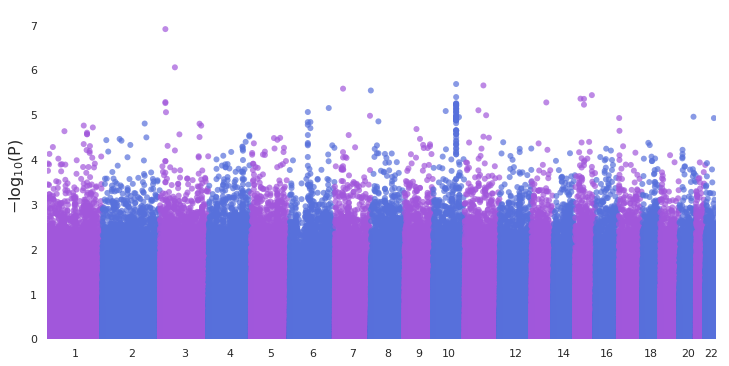

In [6]:
manhattan(df, 22, pval = "pval",ax=None, plot_type='scatter', alpha=.7, line=False)
plt.savefig(os.path.join(fig_dir,'Centralized_manhattan.png'), bbox_inches='tight')

/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b4e04792128>)

<Figure size 432x288 with 0 Axes>

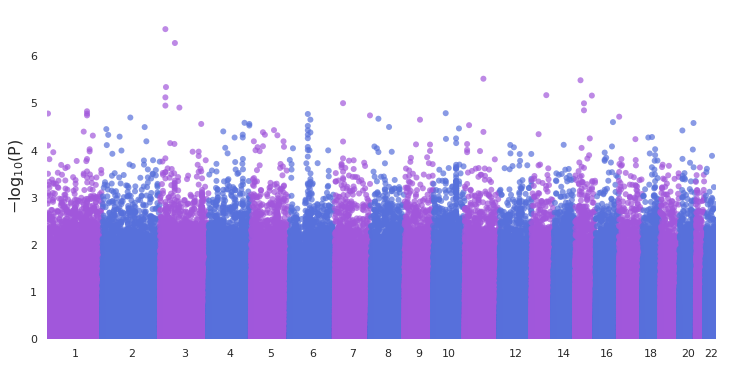

In [7]:
manhattan(total, 22, pval = "pval_m",ax=None, plot_type='scatter', alpha=.7, line=False)

In [8]:
# average contribution 

metaIncluded = [1155749, 1118877, 950783, 1065145, 1014154, 1055218,982738, 1162029]
print(np.mean(metaIncluded)/ 1351793)
print(1204232/1351793)

0.7864270824009297
0.8908405354961891


/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/home/apoursh/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/apoursh/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/apoursh/.local/lib/python3.6/site-package

<Figure size 432x288 with 0 Axes>

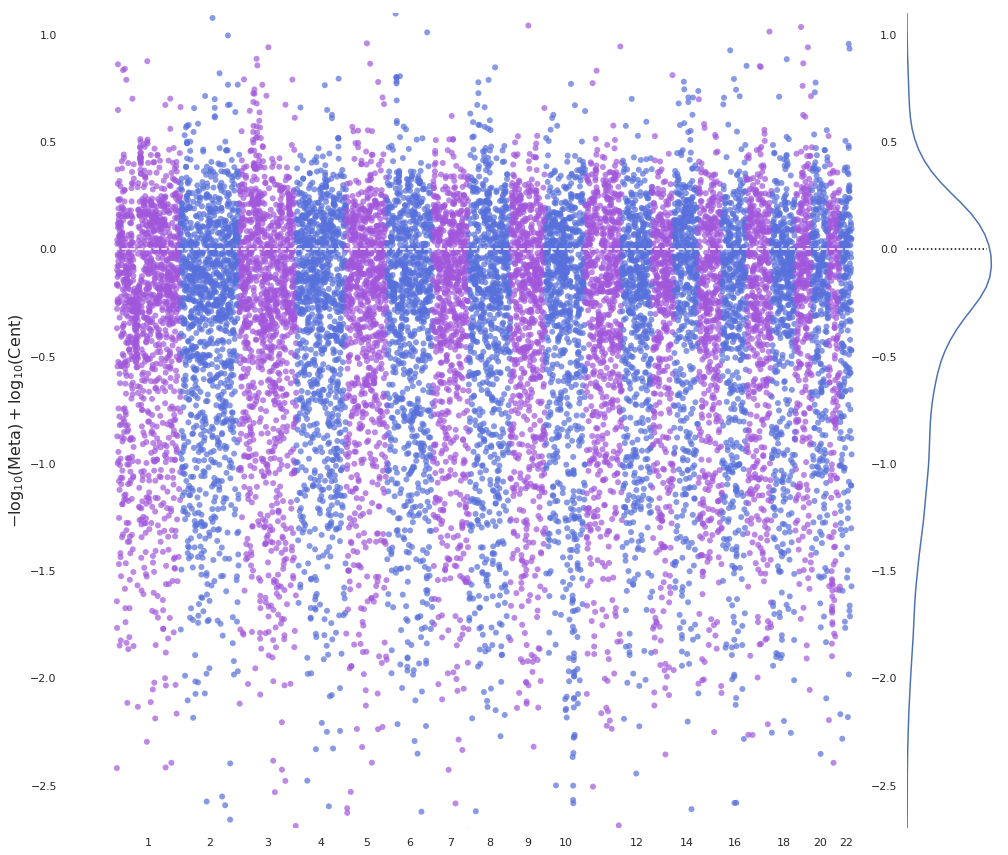

In [9]:
ind = np.logical_or(-np.log10(total.pval_m)>2, -np.log10(total.pval_c)>2)
val = -np.log10(total.pval_m) + np.log10(total.pval_c)
ax, axy = manhattan_diff(total.loc[ind,:], val[ind] ,ax=None, plot_type='scatter',
               alpha=.7, liney=0)


### Below is just a comparison to the original study as a sanity check. Feel free to ignore up until Meta-study header.

In [10]:
originalPage = "/srv/gsfs0/projects/bustamante/apoursh_projects/Hydra/htn.out"
dfo = pd.read_csv(originalPage, sep='\s+', usecols=[1,6,19,21], header=0)
dfo = dfo.dropna()

In [11]:
dfo.columns = ["chrom", "altAF", "pval", "rsid"]
rsids = set(df.rsid)
index = [i for i, rid in enumerate(dfo.rsid) if rid in rsids]
dfo = dfo.iloc[index]

In [12]:
dfo.head()

chrom     altAF      pval         rsid
513       1  0.909606  0.863790    rs3094315
514       1  0.791875  0.965162    rs3131972
796       1  0.011087  0.833684  rs145028227
1142      1  0.074210  0.487555  rs114479279
1148      1  0.109911  0.317631   rs72631880

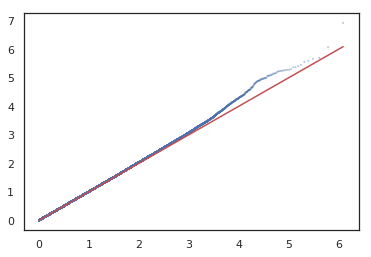

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
x=-np.log10(np.linspace(1,df.shape[0],df.shape[0])/df.shape[0])
y = -np.log10(sorted(df.pval.values))
ax.scatter(x=x,y=y, alpha=.4, edgecolors='none', s=4)
ax.plot(x, x, color='r')
fig.show()

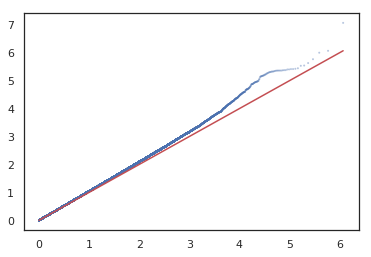

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
x=-np.log10(np.linspace(1,dfo.shape[0],dfo.shape[0])/dfo.shape[0])
y = -np.log10(sorted(dfo.pval))
ax.scatter(x=x,y=y, alpha=.4, edgecolors='none', s=4)
ax.plot(x, x, color='r')
fig.show()

In [15]:
dfmerged = pd.merge(df, dfo, how="left", on=["rsid"])
del dfmerged["chrom_y"]
dfmerged.columns = ["chrom", "pos", "rsid",  "beta", 'pval_me', "AF", "pval_Centralized"]
dfmerged = dfmerged[np.isfinite(dfmerged.pval_Centralized)]

/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b4eaea03cc0>)

<Figure size 432x288 with 0 Axes>

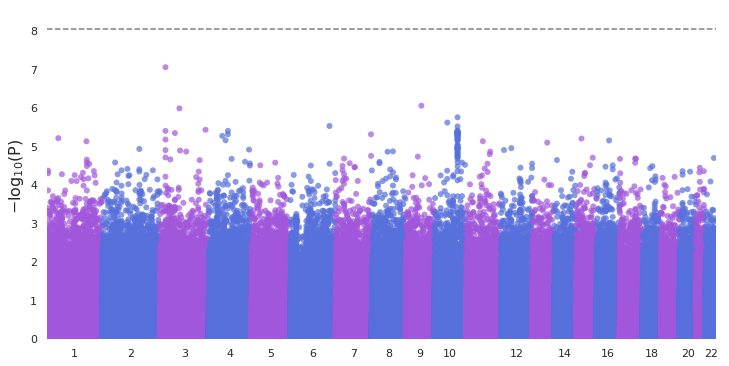

In [16]:
manhattan(dfmerged, 22, pval = "pval_Centralized",ax=None, plot_type='scatter', alpha=.7, line=True)

In [17]:
np.corrcoef(dfmerged.pval_me, dfmerged.pval_Centralized)

array([[1.       , 0.7658855],
       [0.7658855, 1.       ]])

/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b4e047920b8>)

<Figure size 432x288 with 0 Axes>

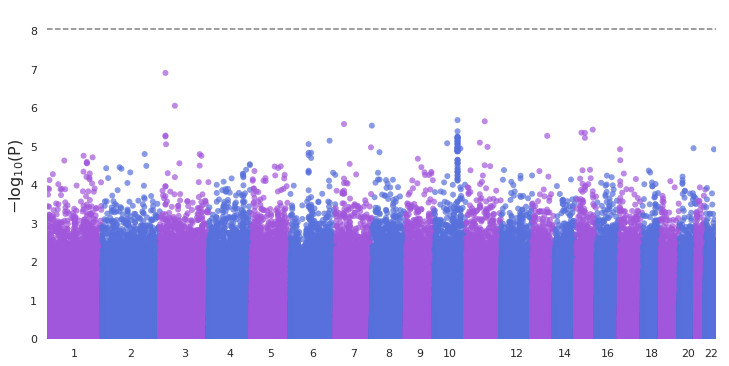

In [18]:
manhattan(dfmerged, 22, pval = "pval_me",ax=None, plot_type='scatter', alpha=.7, line=True)

In [19]:
eps = 0.05
me = np.log10(dfmerged.pval_me[np.logical_and(dfmerged.AF>eps, dfmerged.AF<1-eps)])
good = np.log10(dfmerged.pval_Centralized[np.logical_and(dfmerged.AF>eps, dfmerged.AF<1-eps)])
good = dfmerged.pval_Centralized[np.logical_and(dfmerged.AF>eps, dfmerged.AF<1-eps)]
me = dfmerged.pval_me[np.logical_and(dfmerged.AF>eps, dfmerged.AF<1-eps)]

In [20]:
np.abs(np.abs(me) - np.abs(good)).idxmax(axis=1)

967554

In [21]:
np.max(np.abs(np.abs(me) - np.abs(good)))

0.946204121

In [22]:
np.min(me)

1.19613e-07

In [23]:
np.min(good)

8.507511000000001e-08

In [24]:
np.corrcoef(dfmerged.pval_me, dfmerged.pval_Centralized)

array([[1.       , 0.7658855],
       [0.7658855, 1.       ]])

In [25]:
np.corrcoef(np.abs(np.log10(me)), np.abs(np.log10(good)))

array([[1.        , 0.84086154],
       [0.84086154, 1.        ]])

In [26]:
np.argmax(np.abs(np.abs(me) - np.abs(good)))

/home/apoursh/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


967554

In [27]:
dfmerged.loc[967554]

chrom                        14
pos                   106520845
rsid                rs113899523
beta                -0.00169801
pval_me                 0.94775
AF                      0.32091
pval_Centralized     0.00154588
Name: 967554, dtype: object

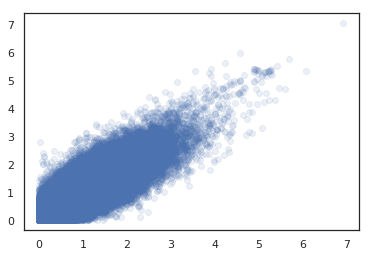

In [28]:
plt.plot(-np.log10(me), -np.log10(good), ls="", marker="o", alpha=0.1)

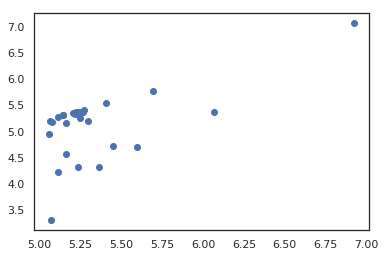

In [29]:
plt.plot(-np.log10(me[me<1e-5]), -np.log10(good[me<1e-5]), ls="", marker="o", alpha=1)

### our centralized version is underpowered compared to the PAGE's original study. That's not surprising given that our sample size is smaller and we don't use pedigree info. 

In [30]:
np.mean((np.log10(good) - np.log10(me)))

-0.007085586052308012

In [31]:
me = sorted(me)
good = sorted(good)

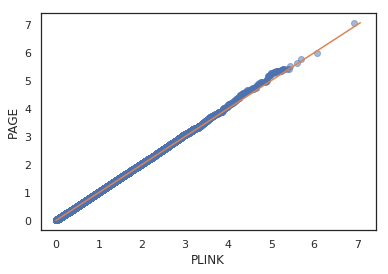

In [32]:
plt.plot(-np.log10(me), -np.log10(good), ls="", marker="o",  alpha = 0.5)
plt.plot(-np.log10(good), -np.log10(good))
plt.ylabel("PAGE")
plt.xlabel("PLINK")
plt.show()

In [33]:
print(np.min(dfo))
print(0.05/dfo.shape[0]) # Damn that's rare ... 

chrom              1
altAF    6.10277e-05
pval     8.50751e-08
rsid      rs10000000
dtype: object
4.241133909562061e-08


/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b4ea1a05a58>)

<Figure size 432x288 with 0 Axes>

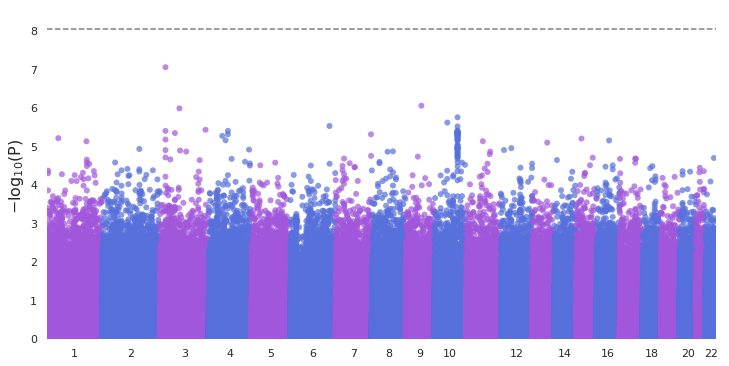

In [34]:
manhattan(dfo, 22, pval = "pval",ax=None, plot_type='scatter', alpha=.7, line=True)

In [35]:
del dfo

# Meta analysis

In [36]:
np.min(total.pval_m)

2.67533e-07

In [37]:
np.min(total.pval_c)

1.19613e-07

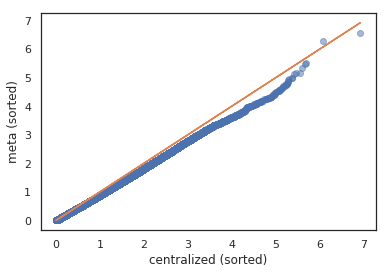

In [38]:
plt.plot(-np.log10(np.sort(total.pval_c)), -np.log10(np.sort(total.pval_m)), ls="", marker="o",  alpha = 0.5)
plt.plot(-np.log10(total.pval_c), -np.log10(total.pval_c))
plt.ylabel("meta (sorted)")
plt.xlabel("centralized (sorted)")
plt.show()

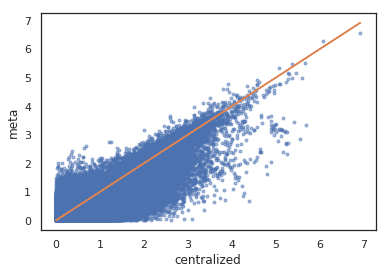

In [39]:
plt.plot(-np.log10(total.pval_c), -np.log10(total.pval_m), ls="", marker="o",  alpha = 0.5, markersize=3)
plt.plot(-np.log10(total.pval_c), -np.log10(total.pval_c))
plt.ylabel("meta")
plt.xlabel("centralized")
plt.show()

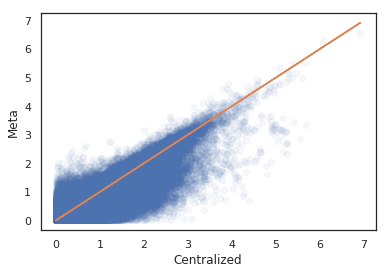

In [40]:
plt.plot(-np.log10(total.pval_c), -np.log10(total.pval_m), ls="", marker="o",  alpha = 0.05)
plt.plot(-np.log10(total.pval_c), -np.log10(total.pval_c))
plt.ylabel("Meta")
plt.xlabel("Centralized")
plt.show()

/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/home/apoursh/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/apoursh/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/apoursh/.local/lib/python3.6/site-package

<Figure size 432x288 with 0 Axes>

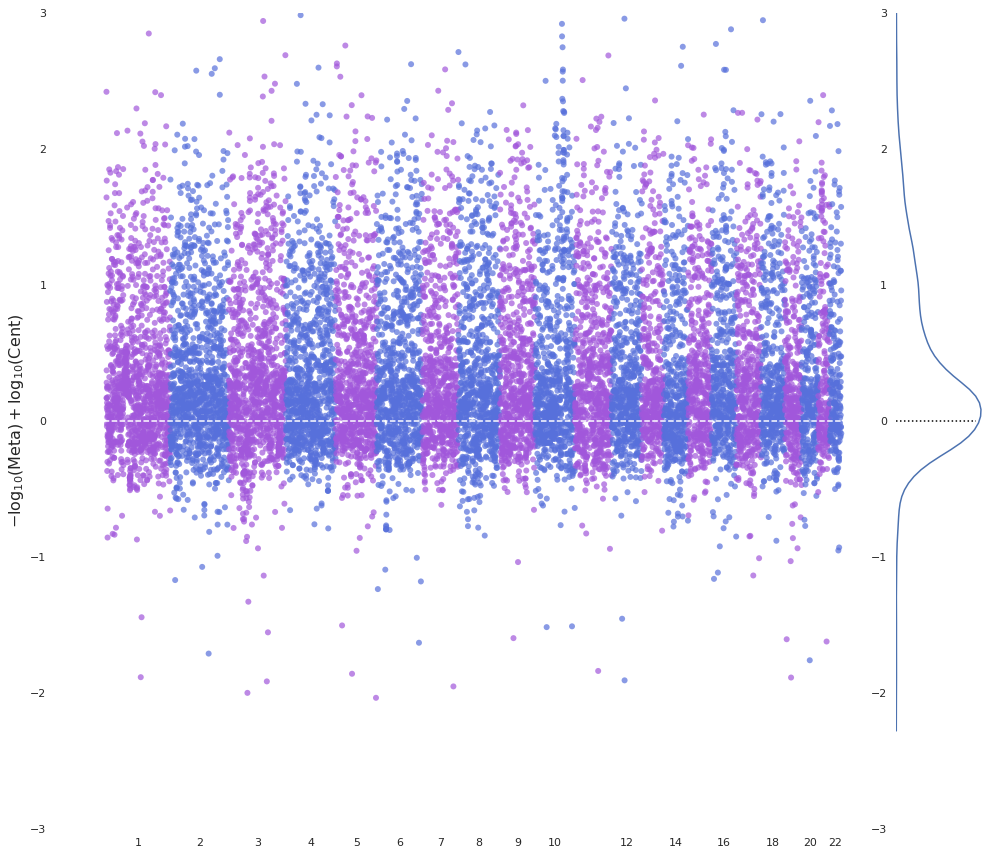

In [41]:
ind = np.logical_or(-np.log10(total.pval_m)>2, -np.log10(total.pval_c)>2)
val = np.log10(total.pval_m) - np.log10(total.pval_c)
ax, axy = manhattan_diff(total.loc[ind,:], val[ind] ,ax=None, plot_type='scatter',
               alpha=.7, liney=0, y_max=3, y_min=-3)
# So this plot can't be right 

# Remember to include a warning about how the density plot could be misleading but is needed to see the pattern

## SWC Data

['PCA_allele_freq', 'PCA_passed', 'PCA_positions', 'allele_freq', 'counts', 'hwe', 'missing_rates', 'positions', 'var']


/home/apoursh/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


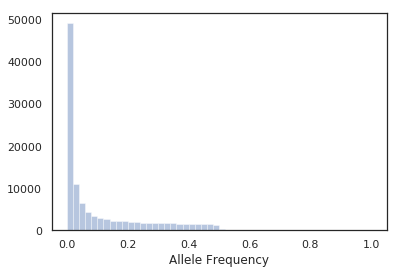

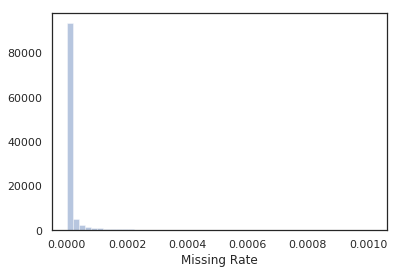

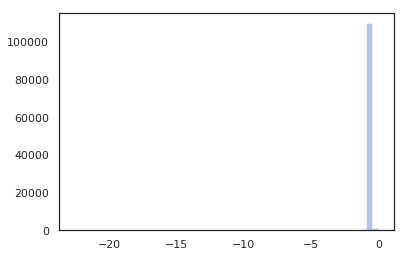

In [42]:
with h5py.File(f"{scratch}/central.h5py", "r") as store:
    print([i for i in store["1"]])
    plt.figure(1)
    sns.distplot(store["1/allele_freq"], kde=False, label="Global allele frequencies", axlabel="Allele Frequency")
    plt.savefig(os.path.join(fig_dir,'allele_frq_chr1.png'), bbox_inches='tight')
    plt.figure(2)
    sns.distplot(store["1/missing_rates"], kde=False, label="Global missing rates", axlabel="Missing Rate");
    plt.savefig(os.path.join(fig_dir,'missing_rates_chr1.png'), bbox_inches='tight')
    plt.figure(3)
    sns.distplot(np.log(store["1/hwe"]), kde=False)

In [43]:
store=h5py.File(f"{scratch}central.h5py", 'r')

In [44]:

my = pd.DataFrame({"pos": store["1/positions"].value, "coef": store["meta/1/newton_coef"].value[:,1][:,0], 
                   'af': store["1/allele_freq"].value})
my.loc[:,"meta2Pval"] = 0.0
my.loc[my.coef != 0, "meta2Pval"] = chi2sf(-2*store["meta/1/newton_ell"].value[:,0],1)
for i in range(2,23):
    temp = pd.DataFrame({"pos": store[f"{i}/positions"].value, "coef": store[f"meta/{i}/newton_coef"].value[:,1][:,0], 
                   'af': store[f"{i}/allele_freq"].value})
    temp.loc[:,"meta2Pval"] = 0.0
    temp.loc[temp.coef != 0, "meta2Pval"] = chi2sf(-2*store[f"meta/{i}/newton_ell"].value[:,0],1)
    my = pd.concat((my, temp))
my = my.loc[~my.duplicated("pos"),:]
#,
                 # "meta2Pval": chi2sf(-2*store["meta/21/newton_ell"].value[:,0],1)})

In [45]:
store["meta/21/newton_coef"].value[:20,12]

array([[-0.1884782 ],
       [-0.1884782 ],
       [-0.1884782 ],
       [-0.1884782 ],
       [-0.1884782 ],
       [-0.1884782 ],
       [-0.18859139],
       [-0.18845576],
       [-0.1884782 ],
       [-0.18856857],
       [-0.18830377],
       [-0.18834584],
       [-0.18851262],
       [-0.18829968],
       [-0.18849314],
       [-0.18849513],
       [-0.1884711 ],
       [-0.1884782 ],
       [-0.1884782 ],
       [-0.1884782 ]])

In [46]:
# I will delete the positions that are not unique. CwS as is, does not support multiallelic loci
print(np.sum(total.duplicated("pos")), np.sum(my.duplicated("pos")))

3962 0


In [47]:
df.shape

(1226053, 5)

In [48]:
total.shape

(1226053, 7)

In [49]:
my.shape

(1329341, 4)

In [50]:
total = total.loc[~total.duplicated("pos"),:]
merged = pd.merge(total, my, on="pos")
print(np.sum(np.isnan(merged.beta_m)))
merged=merged.loc[~np.isnan(merged.beta_m),:]
print(np.sum(merged.coef==0))
merged=merged.loc[merged.coef!=0,:]
print(merged.shape)

24520
191894
(1005677, 10)


/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/home/apoursh/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


-0.04915265678803996


<Figure size 432x288 with 0 Axes>

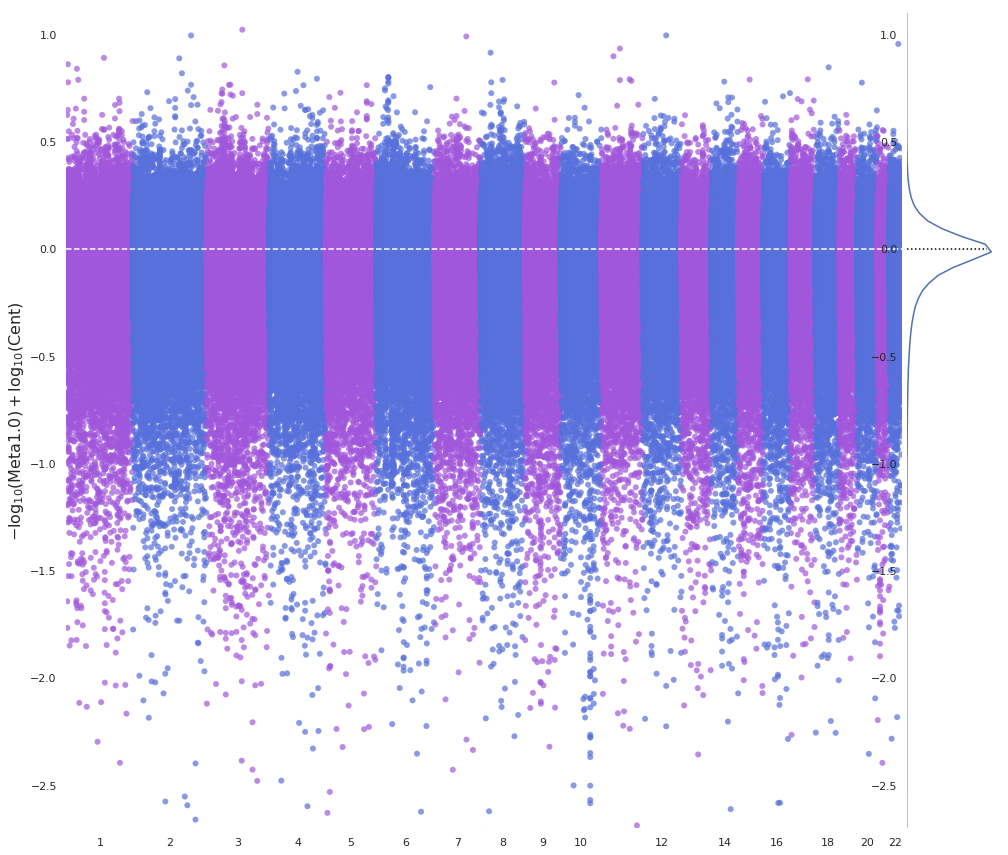

In [51]:
val = -np.log10(merged.pval_m)+np.log10(merged.pval_c)
ax,_ = manhattan_diff(merged, val,ax=None, plot_type='scatter', alpha=.7, liney=0)
ax.set_ylabel(r'$-\log_{10}($Meta1.0$)+\log_{10}($Cent$)$',fontsize=16)
plt.savefig(os.path.join(fig_dir,'mMinusc.png'), bbox_inches='tight')

print(np.mean(val))

/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/home/apoursh/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.0015022039836708671
0.055917668422327135


<Figure size 432x288 with 0 Axes>

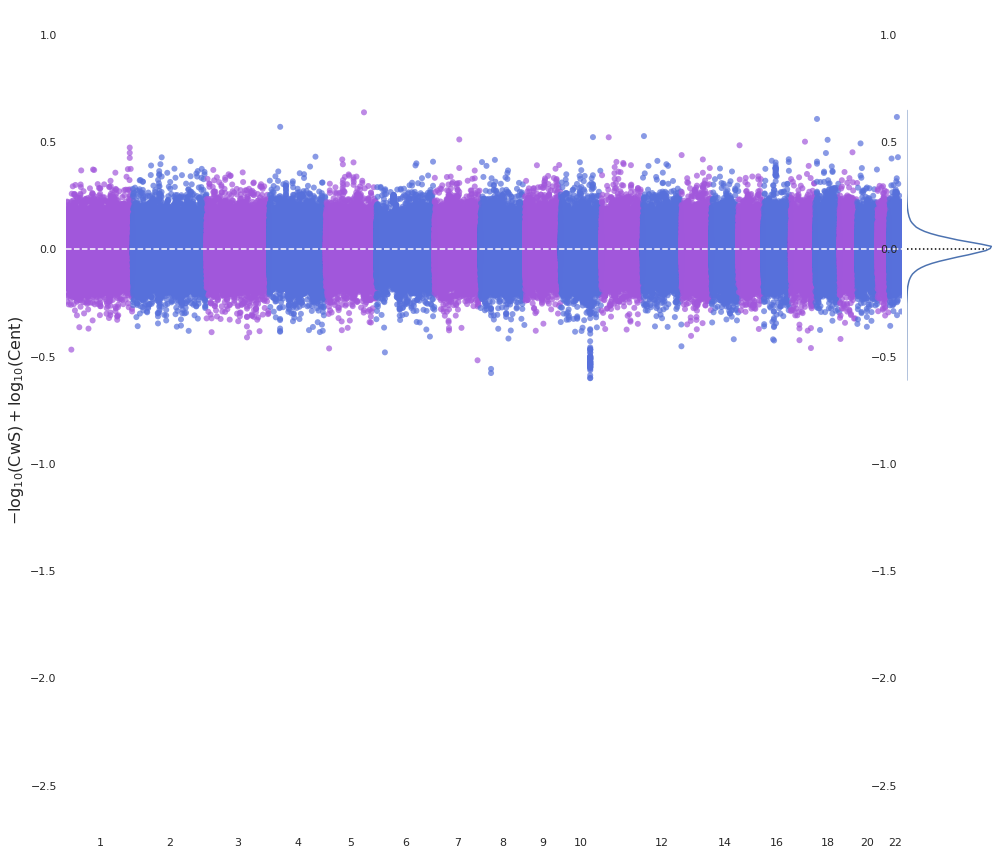

In [52]:
val = -np.log10(merged.meta2Pval) + np.log10(merged.pval_c)
ax, axy=manhattan_diff(merged, val,ax=None, plot_type='scatter', alpha=.7, liney=0)
ax.set_ylabel(r'$-\log_{10}($CwS$)+\log_{10}($Cent$)$',fontsize=16)
plt.savefig(os.path.join(fig_dir,'2Minusc.png'), bbox_inches='tight')
print(np.mean(val))
print(np.std(val))

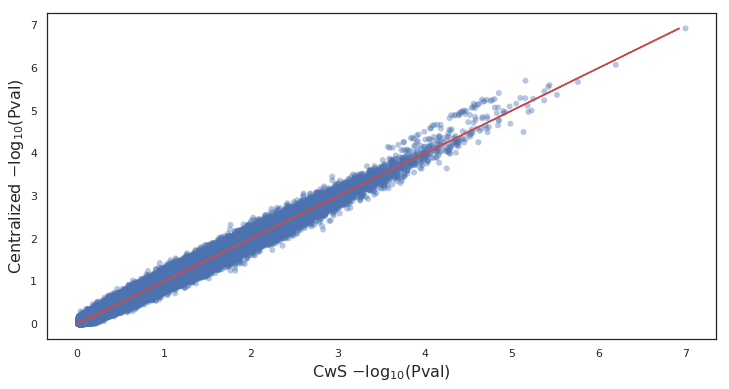

In [53]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(x=-np.log10(merged.meta2Pval), y=-np.log10(merged.pval_c), alpha=.4, edgecolors='none')
ax.plot(-np.log10(merged.pval_c), -np.log10(merged.pval_c), color='r')
ax.set_xlabel(r'CwS $-\log_{10}($Pval$)$',fontsize=16)
ax.set_ylabel(r'Centralized $-\log_{10}($Pval$)$',fontsize=16)
plt.savefig(os.path.join(fig_dir,'2cConcordance.png'), bbox_inches='tight')

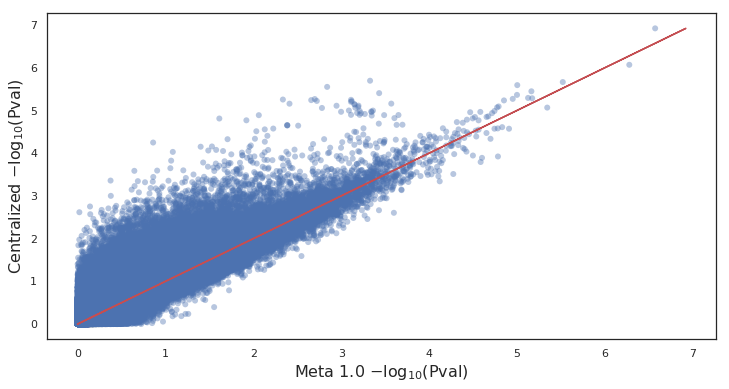

In [54]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(x=-np.log10(merged.pval_m), y=-np.log10(merged.pval_c), alpha=.4, edgecolors='none')
ax.plot(-np.log10(merged.pval_c), -np.log10(merged.pval_c), color='r')
ax.set_xlabel(r'Meta 1.0 $-\log_{10}($Pval$)$',fontsize=16)
ax.set_ylabel(r'Centralized $-\log_{10}($Pval$)$',fontsize=16)
plt.savefig(os.path.join(fig_dir,'mcConcordance.png'), bbox_inches='tight')

/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/home/apoursh/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

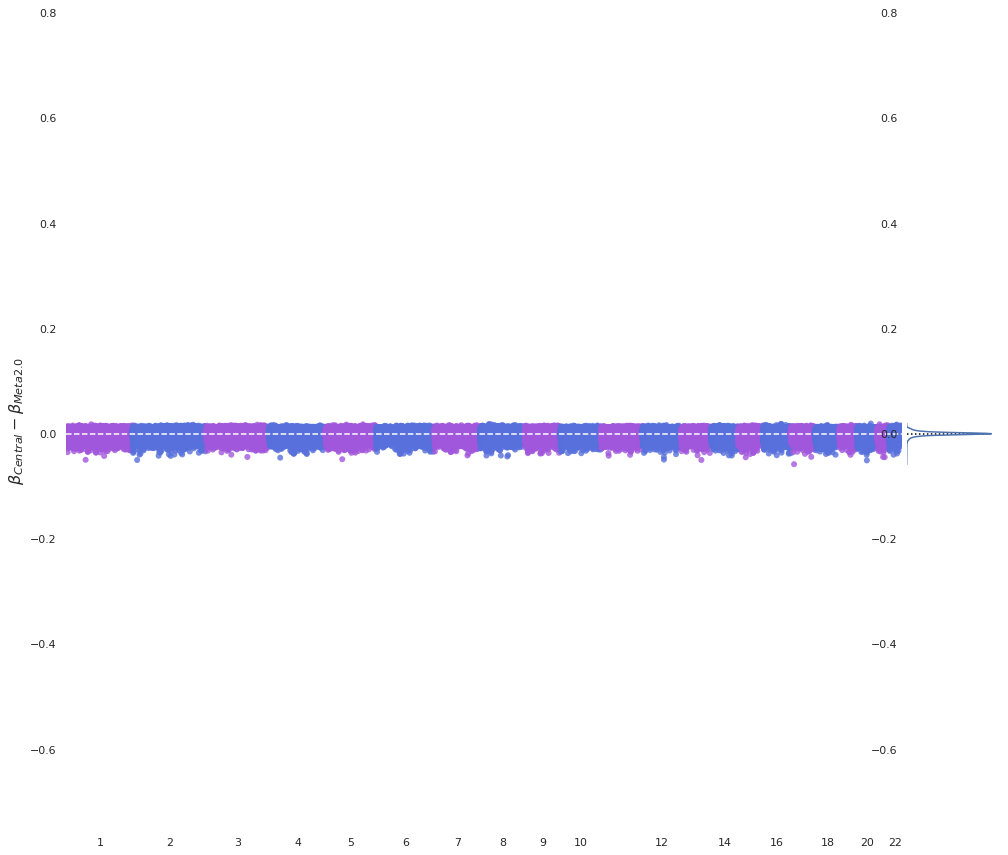

In [55]:
ax,_ = manhattan_diff(merged, merged.beta_c-merged.coef,ax=None, 
                      plot_type='scatter', alpha=.8, liney=0, y_min=-.75,y_max=.8)
ax.set_ylabel(r'$\beta_{Central} - \beta_{Meta2.0}$',fontsize=16)
plt.savefig(os.path.join(fig_dir,'cMinus2_beta.png'), bbox_inches='tight')

/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/home/apoursh/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

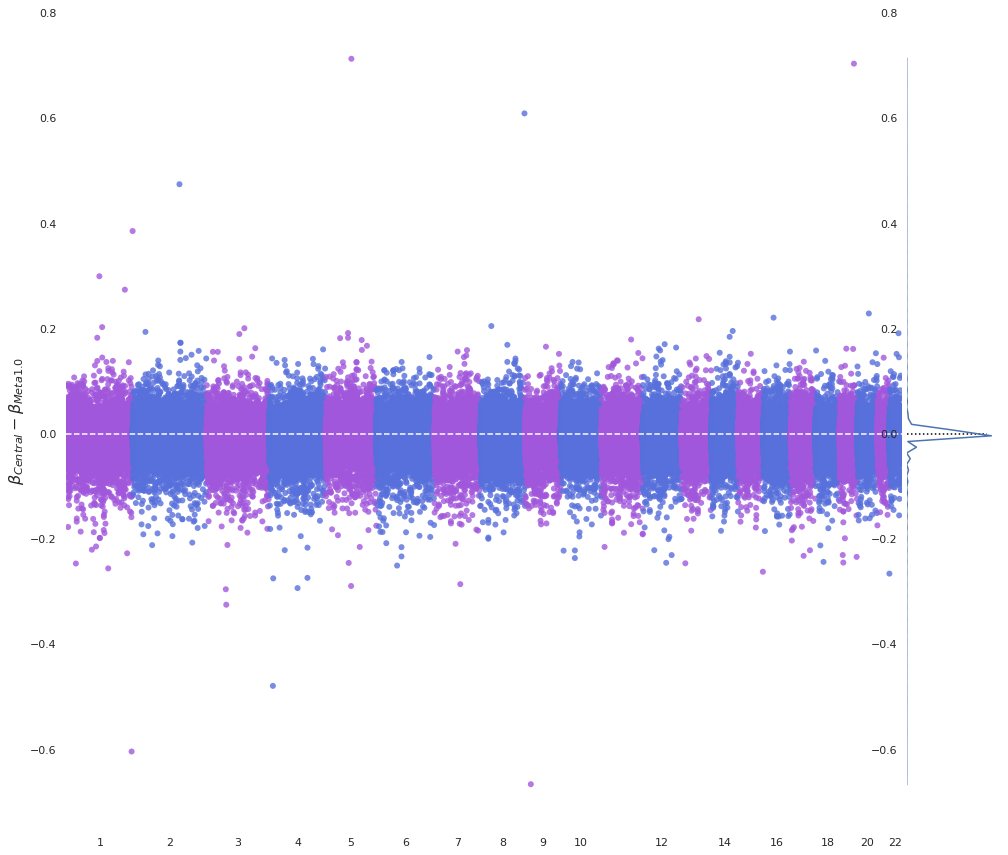

In [56]:
ax,_ = manhattan_diff(merged, merged.beta_c-merged.beta_m,ax=None, plot_type='scatter', alpha=.8, liney=0
                     , y_min=-.75,y_max=.8)
ax.set_ylabel(r'$\beta_{Central} - \beta_{Meta1.0}$',fontsize=16)
plt.savefig(os.path.join(fig_dir,'cMinusm_beta.png'), bbox_inches='tight')

In [57]:
np.std(np.abs(merged.beta_c-merged.beta_m))

0.011334198085806609

In [58]:
np.std(np.abs(merged.beta_c-merged.coef))

0.002971524856498298

In [59]:
np.max(merged.meta2Pval.values) # This is because we solve the first problem not super accurately. 
# shouldn't lead to power overestimation for things that have small pvalue in a significant way

0.9632022290186871

In [60]:
np.max(merged.pval_m.values)

0.999999

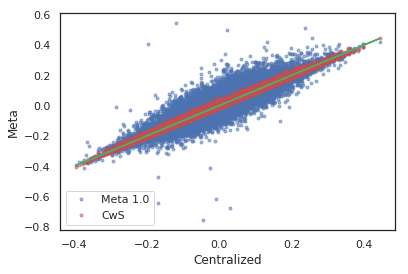

In [61]:
ind = merged.pval_c<1
ax = plt.subplot(1,1,1)
ax.plot(merged.beta_c.loc[ind], merged.beta_m.loc[ind], ls="", marker="o",  alpha = 0.5, markersize=3)
ax.plot(merged.beta_c.loc[ind], merged.coef.loc[ind], ls="", marker="o",  alpha = 0.5, c='r', markersize=3)
ax.plot(merged.beta_c.loc[ind], merged.beta_c.loc[ind] , color='g')
handles, _ = ax.get_legend_handles_labels()
labels = ["Meta 1.0", "CwS"]
plt.ylabel("Meta")
plt.xlabel("Centralized")
ax.legend(handles[:-1], labels)

plt.savefig(os.path.join(fig_dir,'beta_comparison.png'), bbox_inches='tight')
plt.show()

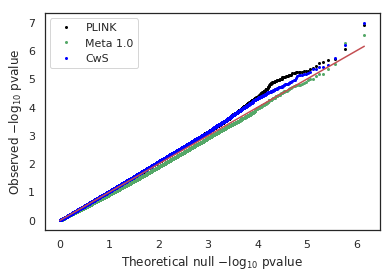

In [62]:
fig = plt.figure()
sns.set(style="white")
ax = fig.add_subplot(111)
osm, osr = -np.log10(scipy.stats.probplot(merged.pval_c, dist=scipy.stats.uniform, fit=False))
ax.plot(osm, osr, marker="o", markersize="2", linestyle='None', color="black", label='PLINK')
osm, osr = -np.log10(scipy.stats.probplot(merged.pval_m, dist=scipy.stats.uniform, fit=False))
ax.plot(osm, osr, marker="o", markersize="2", linestyle='None', color='g', label='Meta 1.0')
osm, osr = -np.log10(scipy.stats.probplot(merged.meta2Pval, dist=scipy.stats.uniform, fit=False))
ax.plot(osm, osr, marker="o", markersize="2", linestyle='None', color='blue', label='CwS')
ax.plot(osm, osm, color='r')
ax.set_xlabel("Theoretical null $-\log_{10}$ pvalue")
ax.set_ylabel("Observed $-\log_{10}$ pvalue")
ax.legend()
plt.savefig(os.path.join(fig_dir,'qqplot.png'), bbox_inches='tight')

In [63]:
from assocplots.qqplot import *
print(get_lambda(merged.pval_c, definition = 'median'))
print(get_lambda(merged.pval_m, definition = 'median'))
print(get_lambda(merged.meta2Pval, definition = 'median'))


1.0440724805896806
0.8534147551503112
1.0484772175022685


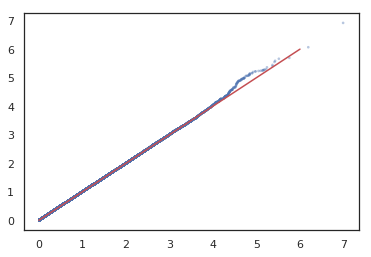

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)
x=-np.log10(np.linspace(1,merged.shape[0],merged.shape[0])/merged.shape[0])
y = -np.log10(sorted(merged.pval_c.values))
ax.scatter(x=-np.log10(sorted(merged.meta2Pval.values)),y=y, alpha=.4, edgecolors='none', s=7)
ax.plot(x, x, color='r')
fig.show()

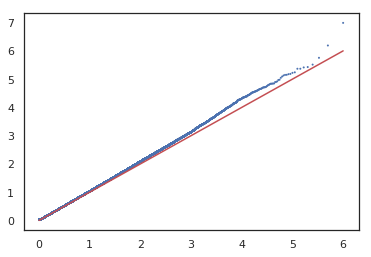

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = -np.log10(np.linspace(1,merged.shape[0]-1,merged.shape[0])/merged.shape[0])
y = -np.log10(sorted(merged.meta2Pval.values))
ax.scatter(x=x,y=y, alpha=1, edgecolors='none', s=4)
ax.plot(x, x, color='r')
fig.show()

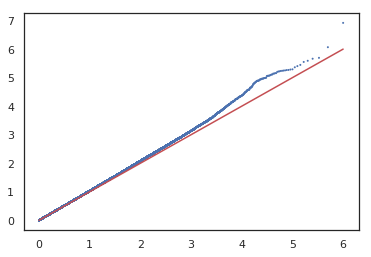

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
x=-np.log10(np.linspace(1,merged.shape[0],merged.shape[0])/merged.shape[0])
y = -np.log10(sorted(merged.pval_c.values))
ax.scatter(x=x,y=y, alpha=1, edgecolors='none', s=4)
ax.plot(x, x, color='r')
fig.show()

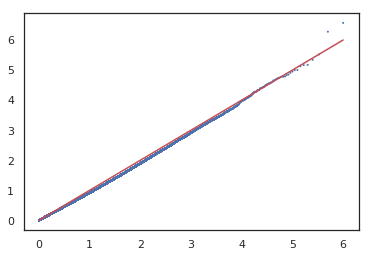

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111)
x=-np.log10(np.linspace(1,merged.shape[0],merged.shape[0])/merged.shape[0])
y = -np.log10(sorted(merged.pval_m.values))
ax.scatter(x=x,y=y, alpha=1, edgecolors='none', s=4)
ax.plot(x, x, color='r')
fig.show()

/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


<Figure size 432x288 with 0 Axes>

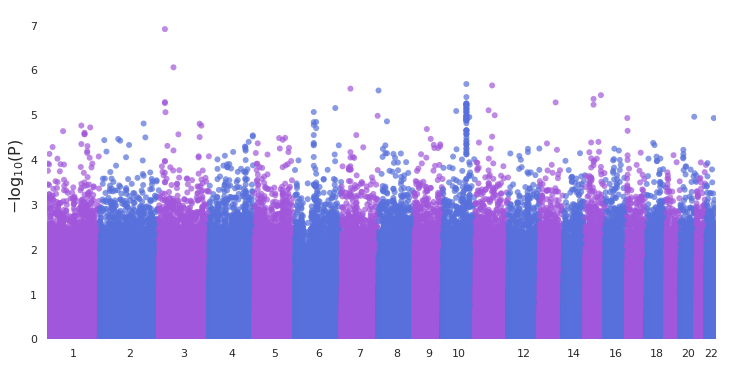

In [68]:
manhattan(merged, 22, pval = "pval_c",ax=None, plot_type='scatter', alpha=.7, line=False)
plt.savefig(os.path.join(fig_dir,'Manhattan_C.png'), bbox_inches='tight')

/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


<Figure size 432x288 with 0 Axes>

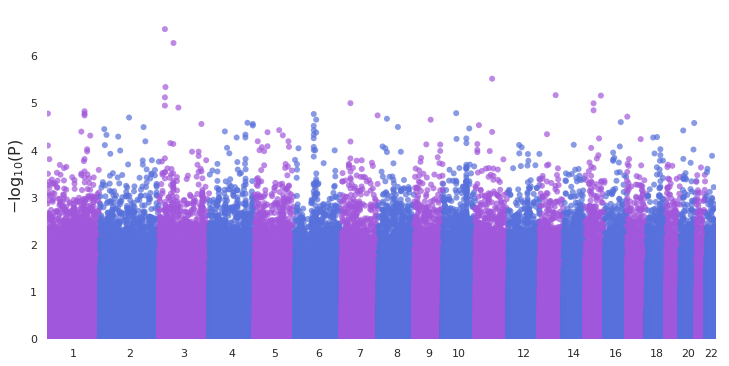

In [69]:
manhattan(merged, 22, pval = "pval_m",ax=None, plot_type='scatter', alpha=.7, line=False)
plt.savefig(os.path.join(fig_dir,'Manhattan_M.png'), bbox_inches='tight')

/home/apoursh/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


<Figure size 432x288 with 0 Axes>

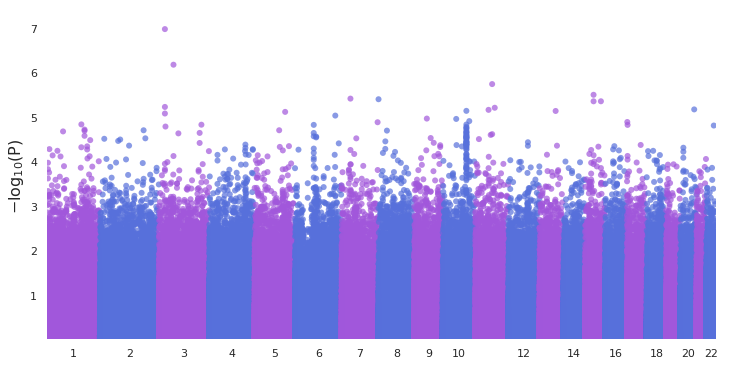

In [70]:
manhattan(merged, 22, pval = "meta2Pval",ax=None, plot_type='scatter', alpha=.7, line=False)
plt.savefig(os.path.join(fig_dir,'Manhattan_2.png'), bbox_inches='tight')

In [71]:

import scipy
bins = [0,.01, .02, .05, .1, .15, .2, .3, 1]
merged["binned_af"] = pd.cut(merged.af, bins)
lam = lambda x : [get_lambda(x.pval_c), get_lambda(x.pval_m), get_lambda(x.meta2Pval)]
res = merged.groupby("binned_af").apply(lambda x : lam (x))

No handles with labels found to put in legend.


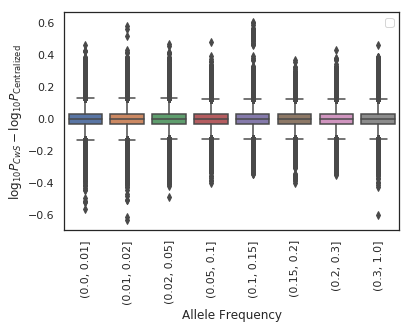

In [72]:
merged["P_of_2_minus_c"] =  np.log10(merged.meta2Pval)-np.log10(merged.pval_c)
ax = sns.boxplot(x="binned_af", y="P_of_2_minus_c", data=merged)
plt.xticks(rotation=90)
plt.xlabel("Allele Frequency")
plt.ylabel(r"$\log_{10} P_{CwS} - \log_{10}P_\mathrm{Centralized}$")
ax.legend()
plt.savefig(os.path.join(fig_dir,'2_Pval_by_AF.png'), bbox_inches='tight')

No handles with labels found to put in legend.


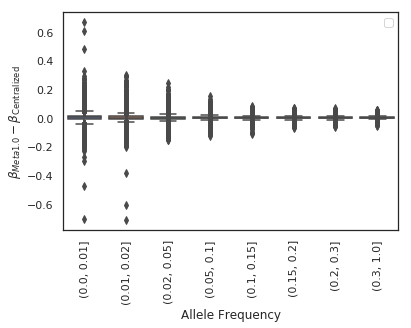

In [73]:
merged["b_of_m_minus_c"] =  merged.beta_m-merged.beta_c
plt.xticks(rotation=90)
ax = sns.boxplot(x="binned_af", y="b_of_m_minus_c", data=merged)
plt.xlabel("Allele Frequency")
plt.ylabel(r"$ \beta_{Meta 1.0} - \beta_\mathrm{Centralized}$")
ax.legend()
plt.savefig(os.path.join(fig_dir,'m_beta_by_AF.png'), bbox_inches='tight')

No handles with labels found to put in legend.


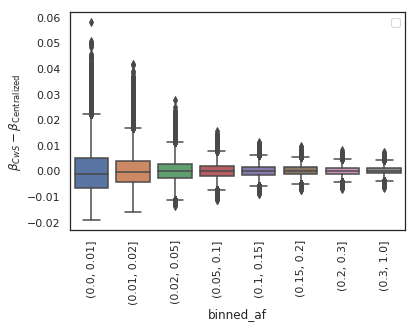

In [74]:
merged["b_of_2_minus_c"] =  merged.coef-merged.beta_c
plt.xticks(rotation=90)
ax = sns.boxplot(x="binned_af", y=merged.coef-merged.beta_c, data=merged)
plt.ylabel(r"$ \beta_{CwS} - \beta_\mathrm{Centralized}$")
ax.legend()
plt.savefig(os.path.join(fig_dir,'2_beta_by_AF.png'), bbox_inches='tight')

No handles with labels found to put in legend.


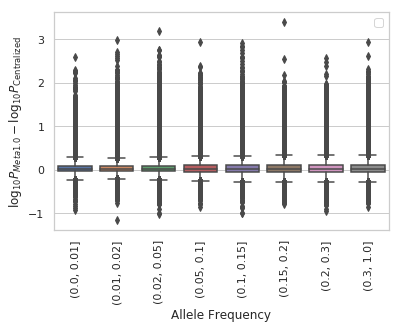

In [75]:
merged["P_of_m_minus_c"] =  np.log10(merged.pval_m)-np.log10(merged.pval_c)
sns.set(style="whitegrid")
ax = sns.boxplot(x="binned_af", y="P_of_m_minus_c", data=merged)
plt.xticks(rotation=90)
plt.xlabel("Allele Frequency")
plt.ylabel(r"$\log_{10} P_{Meta 1.0} - \log_{10}P_\mathrm{Centralized}$")
ax.legend()
plt.savefig(os.path.join(fig_dir,'m_Pval_by_AF.png'), bbox_inches='tight')

In [76]:
merged.groupby("binned_af").P_of_m_minus_c.mean()

binned_af
(0.0, 0.01]     0.052280
(0.01, 0.02]    0.052484
(0.02, 0.05]    0.051278
(0.05, 0.1]     0.051121
(0.1, 0.15]     0.048575
(0.15, 0.2]     0.046764
(0.2, 0.3]      0.045381
(0.3, 1.0]      0.045802
Name: P_of_m_minus_c, dtype: float64

In [77]:
merged.groupby("binned_af").P_of_2_minus_c.std()

binned_af
(0.0, 0.01]     0.057186
(0.01, 0.02]    0.057264
(0.02, 0.05]    0.056493
(0.05, 0.1]     0.055067
(0.1, 0.15]     0.056454
(0.15, 0.2]     0.055257
(0.2, 0.3]      0.054748
(0.3, 1.0]      0.055263
Name: P_of_2_minus_c, dtype: float64

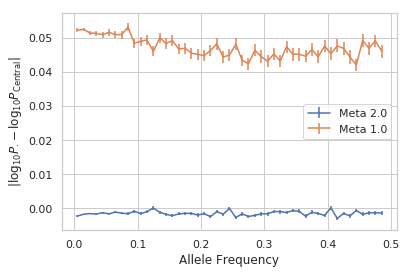

In [78]:
bins = np.array(range(50))/100
merged["binned_af"] = pd.cut(merged.af, bins)

merged.loc["P_of_2_minus_c"] = np.abs(merged.loc[:,"P_of_2_minus_c"])
merged.loc["P_of_m_minus_c"] = np.abs(merged.loc[:,"P_of_m_minus_c"])

fig, ax = plt.subplots(1,1)

ax.errorbar((np.array(bins[:-1]) + bins[1:])/2,merged.groupby("binned_af").P_of_2_minus_c.mean().values, 
           yerr = merged.groupby("binned_af").P_of_2_minus_c.sem().values, label="Meta 2.0")
ax.errorbar((np.array(bins[:-1]) + bins[1:])/2,merged.groupby("binned_af").P_of_m_minus_c.mean().values,
          yerr = merged.groupby("binned_af").P_of_m_minus_c.sem().values, label="Meta 1.0")

plt.xlabel("Allele Frequency")
plt.ylabel(r"$\| \log_{10} P_{\cdot} - \log_{10}P_{\mathrm{Central}}\|$")
ax.legend()
plt.savefig(os.path.join(fig_dir,'Pval_by_AF.png'), bbox_inches='tight')

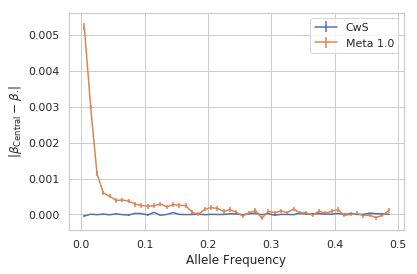

In [79]:
fig, ax = plt.subplots(1,1)
ax.errorbar((np.array(bins[:-1]) + bins[1:])/2,merged.groupby("binned_af").b_of_2_minus_c.mean().values,
        yerr=merged.groupby("binned_af").b_of_2_minus_c.sem().values,
           label="CwS")
ax.errorbar((np.array(bins[:-1]) + bins[1:])/2,merged.groupby("binned_af").b_of_m_minus_c.mean().values,
            yerr=merged.groupby("binned_af").b_of_m_minus_c.sem().values, label="Meta 1.0")
handles, _ = ax.get_legend_handles_labels()
plt.xlabel("Allele Frequency")
plt.ylabel(r"$\|\beta_{\mathrm{Central}} - \beta_{\cdot}\|$")
ax.legend()
plt.savefig(os.path.join(fig_dir,'beta_by_AF.png'), bbox_inches='tight')

# PCS 

In [80]:
pcsdf  = pd.read_csv(home+"/page/workinsubset/pageii_pcs.eigenvec", "\t")
phenodf = pd.read_csv(home+"/page/workinsubset/page.binary_pheno.for_armin.jan24_2018.txt", " ")
phenodf = phenodf.loc[:, [i not in range(6,16) for i in range(23)]]

In [81]:
df = pd.merge(pcsdf, phenodf, left_on="#FID", right_on="page_subject_id")
df.loc[df.center == "MEC:CA", "center"] = "MEC_CA"
df.loc[df.center == "MEC:HI", "center"] = "MEC_HI"
df.loc[df.center == "SOL:B", "center"] = "SOL_B"
df.loc[df.center == "SOL:C", "center"] = "SOL_C"
df.loc[df.center == "SOL:S", "center"] = "SOL_S"
df.loc[df.center == "SOL:M", "center"] = "SOL_M"
df.loc[df.center == "WHI:", "center"] = "WHI"
df.loc[df.center == "BioME:", "center"] = "BioME"

df.loc[df.race_ethnicity == 2, "race_ethnicity"] = "AA"
df.loc[df.race_ethnicity == 3, "race_ethnicity"] = "H/L"
df.loc[df.race_ethnicity == 4, "race_ethnicity"] = "AS"
df.loc[df.race_ethnicity == 5, "race_ethnicity"] = "NH"
df.loc[df.race_ethnicity == 6, "race_ethnicity"] = "NA"
df.loc[df.race_ethnicity == 7, "race_ethnicity"] = "OT"

del df["page_subject_id.1"], df["IID"]

In [82]:
df.loc[:,"race_ethnicity"] = (df.loc[:,"race_ethnicity"])

In [83]:
eth = ["AA", "H/L", "AS", "NH", "NA", "OT"]
colors = ["crimson", "b", "g", "magenta", "darkgoldenrod", "yellow"]
palette = dict((key, val) for key, val in zip(eth, colors))

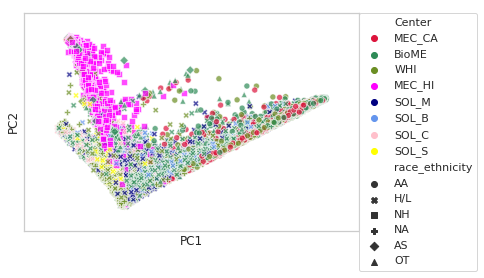

In [84]:
sns.set_style("whitegrid", {'axes.grid': False})
sns.despine()
ax = sns.scatterplot(x="PC1", y="PC2", hue="center", 
                data=df, palette=["crimson", "seagreen", "olivedrab", "magenta", 
                                  "navy", "cornflowerblue", "pink", "yellow"], alpha=.7, style="race_ethnicity")
ax.set_yticks([])
ax.set_xticks([])
ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.).texts[0].set_text("Center")
# ax.legend( )


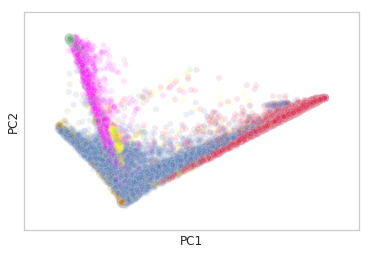

In [85]:
sns.set_style("whitegrid", {'axes.grid': False})
sns.despine()

ax = sns.scatterplot(x="PC1", y="PC2", hue="race_ethnicity", 
                data=df, palette=palette,
               alpha=.1, legend=False)


ax.set_yticks([])
ax.set_xticks([])
plt.savefig(os.path.join(fig_dir,'PC_by_Ethnicity.png'), bbox_inches='tight')

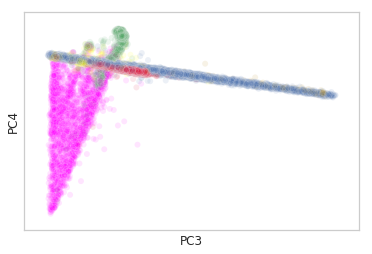

In [86]:
sns.set_style("whitegrid", {'axes.grid': False})
sns.despine()

ax = sns.scatterplot(x="PC3", y="PC4", hue="race_ethnicity", 
                data=df, palette=palette,
               alpha=.1, legend=False)


ax.set_yticks([])
ax.set_xticks([])
plt.savefig(os.path.join(fig_dir,'PC_34_by_Ethnicity.png'), bbox_inches='tight')

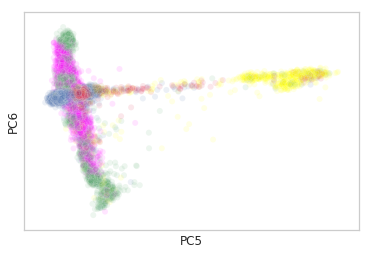

In [87]:
sns.set_style("whitegrid", {'axes.grid': False})
sns.despine()

ax = sns.scatterplot(x="PC5", y="PC6", hue="race_ethnicity", 
                data=df, palette=palette,
               alpha=.1, legend=False)


ax.set_yticks([])
ax.set_xticks([])
plt.savefig(os.path.join(fig_dir,'PC_56_by_Ethnicity.png'), bbox_inches='tight')

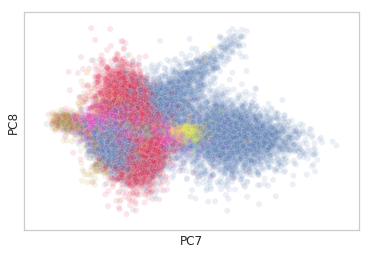

In [88]:
sns.set_style("whitegrid", {'axes.grid': False})
sns.despine()

ax = sns.scatterplot(x="PC7", y="PC8", hue="race_ethnicity", 
                data=df, palette=palette,
               alpha=.1, legend=False)


ax.set_yticks([])
ax.set_xticks([])
plt.savefig(os.path.join(fig_dir,'PC_78_by_Ethnicity.png'), bbox_inches='tight')

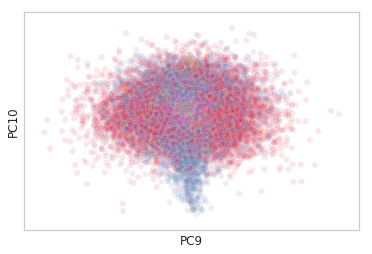

In [89]:
sns.set_style("whitegrid", {'axes.grid': False})
sns.despine()

ax = sns.scatterplot(x="PC9", y="PC10", hue="race_ethnicity", 
                data=df, palette=palette,
               alpha=.1, legend=False)


ax.set_yticks([])
ax.set_xticks([])
plt.savefig(os.path.join(fig_dir,'PC_910_by_Ethnicity.png'), bbox_inches='tight')

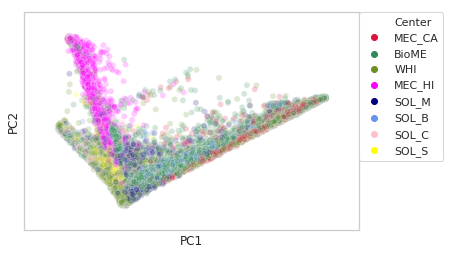

In [90]:
sns.set_style("whitegrid", {'axes.grid': False})
sns.despine()
ax = sns.scatterplot(x="PC1", y="PC2", hue="center", 
                data=df, palette=["crimson", "seagreen", "olivedrab", "magenta", 
                                  "navy", "cornflowerblue", "pink", "yellow"], alpha=.2)
ax.legend(
          bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.).texts[0].set_text("Center")
ax.set_yticks([])
ax.set_xticks([])
plt.savefig(os.path.join(fig_dir,'PC_by_center.png'), bbox_inches='tight')
# ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.).texts[0].set_text("Center")

## Decentralized

In [91]:
d = {f"dPC{i}":[] for i in range(1,11)}
d["dCenter"]=[]
d["ID"] = []
ddf = pd.DataFrame(d)
for center in centers:
    store = h5py.File(f"{scratch}{center}", 'r')
    us = store["meta/pca_u"].value
    us
    d = {f"dPC{i}":us[:,i-1] for i in range(1,11)}
    d["dCenter"] = center
    d["ID"] = [k.decode('unicode_escape') for k in store["meta/id"].value.astype(object)]
    ddftemp = pd.DataFrame(d)
    ddf = ddf.append(ddftemp)
    store.close()
ddf = ddf.reset_index(drop=True)
tdf = pd.merge(df, ddf, left_on="#FID", right_on="ID")
del ddf
for i in range(1, 11):
    tdf[f"dPC{i}"]/=np.std(tdf[f"dPC{i}"])/np.std(tdf[f"PC{i}"])
# df = tdf

In [92]:
store = h5py.File(f"{scratch}{center}", 'r')
v = store["meta/pca_v.T"].value
store.close()

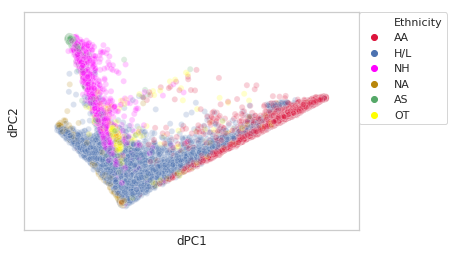

In [93]:
sns.set_style("whitegrid", {'axes.grid': False})
sns.despine()
ax = sns.scatterplot(x="dPC1", y="dPC2", hue="race_ethnicity", 
                data=tdf, palette=palette, alpha=.2)
ax.legend(
          bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.).texts[0].set_text("Ethnicity")

ax.set_yticks([])
ax.set_xticks([])
plt.savefig(os.path.join(fig_dir,'dPC_by_Ethnicity.png'), bbox_inches='tight')
# ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.).texts[0].set_text("Center")

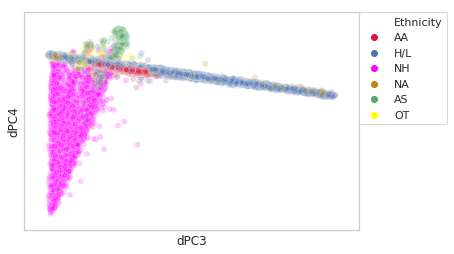

In [94]:
sns.set_style("whitegrid", {'axes.grid': False})
sns.despine()
ax = sns.scatterplot(x="dPC3", y=-tdf.dPC4, hue="race_ethnicity", 
                data=tdf, palette=palette, alpha=.2)
ax.legend(
          bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.).texts[0].set_text("Ethnicity")

ax.set_yticks([])
ax.set_xticks([])
plt.savefig(os.path.join(fig_dir,'dPC_34_by_Ethnicity.png'), bbox_inches='tight')
# ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.).texts[0].set_text("Center")

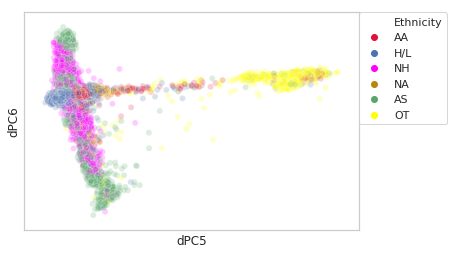

In [95]:
sns.set_style("whitegrid", {'axes.grid': False})
sns.despine()
ax = sns.scatterplot(x="dPC5", y=-tdf.dPC6, hue="race_ethnicity", 
                data=tdf, palette=palette, alpha=.2)
ax.legend(
          bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.).texts[0].set_text("Ethnicity")

ax.set_yticks([])
ax.set_xticks([])
plt.savefig(os.path.join(fig_dir,'dPC_56_by_Ethnicity.png'), bbox_inches='tight')
# ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.).texts[0].set_text("Center")

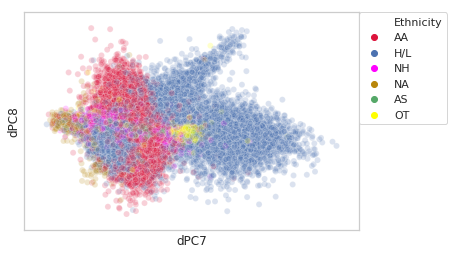

In [96]:
sns.set_style("whitegrid", {'axes.grid': False})
sns.despine()
ax = sns.scatterplot(x=-tdf.dPC7, y=-tdf.dPC8, hue="race_ethnicity", 
                data=tdf, palette=palette, alpha=.2)
ax.legend(
          bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.).texts[0].set_text("Ethnicity")

ax.set_yticks([])
ax.set_xticks([])
plt.savefig(os.path.join(fig_dir,'dPC_78_by_Ethnicity.png'), bbox_inches='tight')
# ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.).texts[0].set_text("Center")

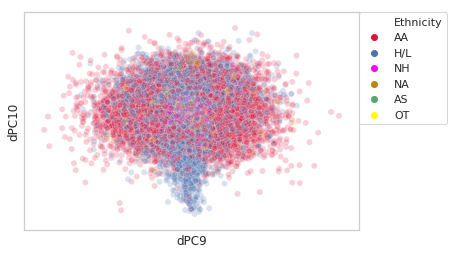

In [97]:
sns.set_style("whitegrid", {'axes.grid': False})
sns.despine()
ax = sns.scatterplot(x="dPC9", y="dPC10", hue="race_ethnicity", 
                data=tdf, palette=palette, alpha=.2)
ax.legend(
          bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.).texts[0].set_text("Ethnicity")

ax.set_yticks([])
ax.set_xticks([])
plt.savefig(os.path.join(fig_dir,'dPC_910_by_Ethnicity.png'), bbox_inches='tight')
# ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.).texts[0].set_text("Center")

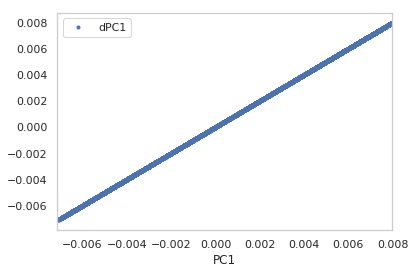

In [98]:
tdf.plot("PC1", "dPC1", style=".")

In [99]:
[scipy.stats.spearmanr(tdf[f"PC{k}"], tdf[f"dPC{k}"])[0] for k in range(1,11)]

[0.9999999999542523,
 0.9999999999462182,
 0.9999999999768973,
 -0.9999999999781045,
 0.9999999998809477,
 -0.9999999913857792,
 -0.9999999547790035,
 -0.9998903152075327,
 0.9994380308562776,
 0.9994272744075142]

In [100]:
df.columns

Index(['#FID', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9',
       'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'page_subject_id',
       'SUBJECT_ID', 'htn', 'ckd_analysis', 'esrd_analysis', 'study', 'center',
       'race_ethnicity', 'sex', 'age', 'BMI.clean', 'hl_class_7'],
      dtype='object')

In [101]:
print(np.std(tdf.dPC1))
print(np.std(tdf.dPC2))
print(np.std(tdf.dPC3))
print(np.std(tdf.dPC4))
print(np.std(tdf.dPC5))
print(np.std(tdf.dPC6))
print(np.std(tdf.dPC7))

0.00490202
0.0049020196
0.0049020196
0.0049020196
0.0049020196
0.004902019
0.0049020196


In [102]:
print(np.std(df.PC1))
print(np.std(df.PC2))
print(np.std(df.PC3))
print(np.std(df.PC4))
print(np.std(df.PC5))
print(np.std(df.PC6))
print(np.std(df.PC7))

0.004902019688788544
0.004902019720565104
0.0049020197240024965
0.004902019626740077
0.004902019810508817
0.004902019532962749
0.004902019823037385


In [103]:
pcsdf  = pd.read_csv(home+"/page/splitted/BioME/covariate_pcs.eigenvec", "\t")
pcsdf['#FID'] = pcsdf['#FID'].astype(str).astype(object)
dfbiome = pd.merge(pcsdf, phenodf, left_on="#FID", right_on="page_subject_id")
del dfbiome["page_subject_id.1"], dfbiome["IID"]

page/splitted/SOL_S/covariate_pcs.eigenvec


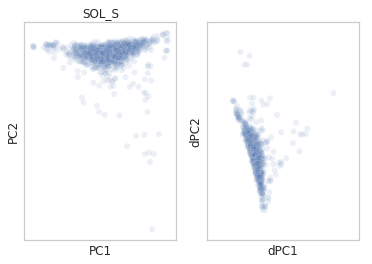

page/splitted/SOL_B/covariate_pcs.eigenvec


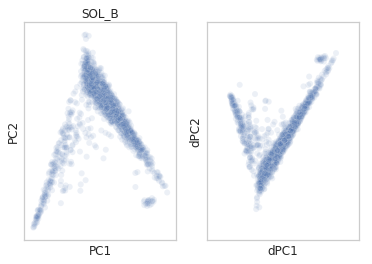

page/splitted/SOL_C/covariate_pcs.eigenvec


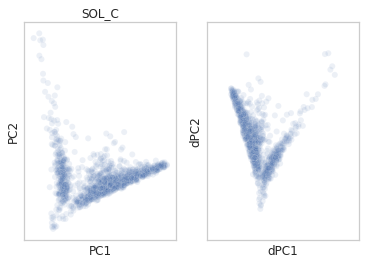

page/splitted/MEC_CA/covariate_pcs.eigenvec


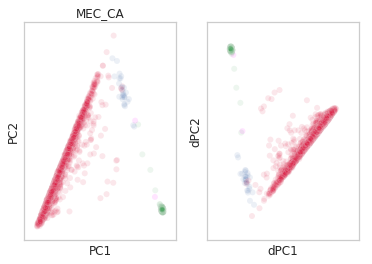

page/splitted/MEC_HI/covariate_pcs.eigenvec


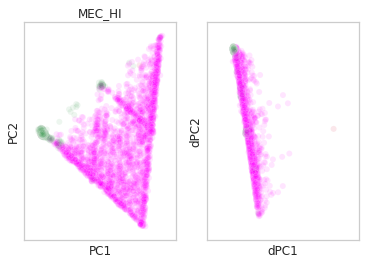

page/splitted/BioME/covariate_pcs.eigenvec


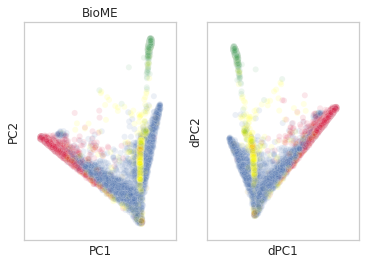

page/splitted/SOL_M/covariate_pcs.eigenvec


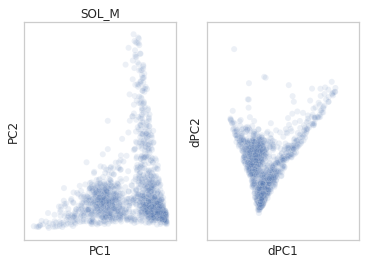

page/splitted/WHI/covariate_pcs.eigenvec


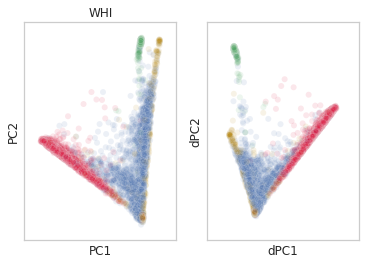

In [104]:
allpcs = ["{}covariate_pcs.eigenvec".format(path) for path in glob.glob("page/splitted/*/")]
for ev in allpcs:
    print(ev)
    pcsdf  = pd.read_csv(ev, "\t")
    pcsdf['#FID'] = pcsdf['#FID'].astype(str).astype(object)
    dfsub = pd.merge(pcsdf, phenodf, left_on="#FID", right_on="page_subject_id")
    del dfsub["page_subject_id.1"], dfsub["IID"]
    dfsub.loc[dfsub.race_ethnicity == 2, "race_ethnicity"] = "AA"
    dfsub.loc[dfsub.race_ethnicity == 3, "race_ethnicity"] = "H/L"
    dfsub.loc[dfsub.race_ethnicity == 4, "race_ethnicity"] = "AS"
    dfsub.loc[dfsub.race_ethnicity == 5, "race_ethnicity"] = "NH"
    dfsub.loc[dfsub.race_ethnicity == 6, "race_ethnicity"] = "NA"
    dfsub.loc[dfsub.race_ethnicity == 7, "race_ethnicity"] = "OT"
    sns.set_style("whitegrid", {'axes.grid': False})
    sns.despine()
    plt.subplot(1, 2, 1)
    ax = sns.scatterplot(x="PC1", y="PC2", hue="race_ethnicity", 
                data=dfsub, palette=palette,
               alpha=.1, legend=False)
    ax.set_yticks([])
    ax.set_xticks([])
    center = os.path.basename(os.path.dirname(ev))
    plt.title(center)
    plt.subplot(1, 2, 2)
    ax = sns.scatterplot(x="dPC1", y="dPC2", hue="race_ethnicity", 
                data=tdf[tdf.dCenter==center+"_ppl.h5py"], palette=palette,
               alpha=.1, legend=False)
    ax.set_yticks([])
    ax.set_xticks([])
    plt.savefig(os.path.join(fig_dir,f'PCs_{center}.png'), bbox_inches='tight')
    plt.show()
    

## QC comparisons 

In [105]:
def comparator(true, splitted):
    splits = ["{}{}".format(path, splitted) for path in glob.glob("page/splitted/*/")]
    all_splitted_plinks = set()
    initialized = False
    for file in splits:
        print(file)
        locis = plinkfile.open(file).get_loci()
        thisFile = set([loci.name for loci in locis])
        if not initialized:
            all_splitted_plinks = thisFile
            initialized = True
        else:
            all_splitted_plinks = all_splitted_plinks.intersection(thisFile)
    trueSnps = set([item.name for item in plinkfile.open(true).get_loci()])
    jakkard = len(all_splitted_plinks.intersection(trueSnps))/len(all_splitted_plinks.union(trueSnps))
    return len(trueSnps), len(all_splitted_plinks), jakkard

In [106]:
comparator("page/workinsubset/pageii_start", "_ppl")

page/splitted/SOL_S/_ppl
page/splitted/SOL_B/_ppl
page/splitted/SOL_C/_ppl
page/splitted/MEC_CA/_ppl
page/splitted/MEC_HI/_ppl
page/splitted/BioME/_ppl
page/splitted/SOL_M/_ppl
page/splitted/WHI/_ppl


(1334683, 1334683, 1.0)

In [107]:
comparator("page/workinsubset/pageii_geno", "_geno")

page/splitted/SOL_S/_geno
page/splitted/SOL_B/_geno
page/splitted/SOL_C/_geno
page/splitted/MEC_CA/_geno
page/splitted/MEC_HI/_geno
page/splitted/BioME/_geno
page/splitted/SOL_M/_geno
page/splitted/WHI/_geno


(1334683, 1334522, 0.9998763753245148)

In [108]:
comparator("page/workinsubset/pageii_hwe", "_hwe")

page/splitted/SOL_S/_hwe
page/splitted/SOL_B/_hwe
page/splitted/SOL_C/_hwe
page/splitted/MEC_CA/_hwe
page/splitted/MEC_HI/_hwe
page/splitted/BioME/_hwe
page/splitted/SOL_M/_hwe
page/splitted/WHI/_hwe


(1334084, 1334302, 0.9995219226204035)

In [109]:
comparator("page/workinsubset/pageii_maf", "_maf")

page/splitted/SOL_S/_maf
page/splitted/SOL_B/_maf
page/splitted/SOL_C/_maf
page/splitted/MEC_CA/_maf
page/splitted/MEC_HI/_maf
page/splitted/BioME/_maf
page/splitted/SOL_M/_maf
page/splitted/WHI/_maf


(477867, 340272, 0.7120534873501161)

In [110]:
comparator("page/workinsubset/pageii_pruned", "pruned")

page/splitted/SOL_S/pruned
page/splitted/SOL_B/pruned
page/splitted/SOL_C/pruned
page/splitted/MEC_CA/pruned
page/splitted/MEC_HI/pruned
page/splitted/BioME/pruned
page/splitted/SOL_M/pruned
page/splitted/WHI/pruned


(134091, 14994, 0.1104200804409355)